<a href="https://colab.research.google.com/github/NeyderManda/Calculadora-IMC/blob/main/lsmt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np
import unicodedata
import re
import os
import requests
import zipfile
import io

# --- 1. Adquisición del Corpus (Solución al Error 406) ---
print("Descargando dataset manualmente para evitar bloqueo del servidor...")

url = "http://www.manythings.org/anki/spa-eng.zip"
# Headers para simular un navegador real
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

response = requests.get(url, headers=headers)

# Verificar si la descarga fue exitosa
if response.status_code == 200:
    print("Descarga exitosa. Descomprimiendo...")
    z = zipfile.ZipFile(io.BytesIO(response.content))
    z.extractall("/content/") # Extraer en la carpeta base de Colab
    path_to_file = "/content/spa.txt"
    print(f"Dataset listo en: {path_to_file}")
else:
    print(f"Error al descargar: {response.status_code}")

# --- 2. Preprocesamiento y Limpieza ---
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # Crear espacio entre palabra y puntuación
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # Reemplazar todo lo que no sea letras y signos de puntuación básicos por espacio
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.strip()

    # Agregar tokens de inicio y fin
    w = '<start> ' + w + ' <end>'
    return w

# Cargar y limpiar datos
def create_dataset(path, num_examples):
    # Abrimos el archivo asegurando codificación UTF-8
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]
    return zip(*word_pairs)

# Usaremos 30,000 oraciones.
# ES (Source) -> EN (Target). Nota: El archivo original es "English + Tab + Spanish"
try:
    # El formato de manythings es "ENG \t SPA", así que al hacer zip(*word_pairs)
    # la primera lista es ENG y la segunda es SPA.
    # Vamos a capturarlo genéricamente y luego asignar.
    eng_raw, spa_raw = create_dataset(path_to_file, 30000)

    # Queremos traducir de Español (Input) a Inglés (Target)
    es = spa_raw
    en = eng_raw

    print("Ejemplo Source (ES):", es[-1])
    print("Ejemplo Target (EN):", en[-1])

except Exception as e:
    print(f"Error procesando el dataset: {e}")

# --- 3. Tokenización y Vectorización ---
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    # Padding: Post-padding
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

if 'es' in locals():
    input_tensor, inp_lang = tokenize(es)
    target_tensor, targ_lang = tokenize(en)

    max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

    # Configuración del Dataset para GPU
    BUFFER_SIZE = len(input_tensor)
    BATCH_SIZE = 64
    steps_per_epoch = len(input_tensor)//BATCH_SIZE
    embedding_dim = 256
    units = 1024
    vocab_inp_size = len(inp_lang.word_index)+1
    vocab_tar_size = len(targ_lang.word_index)+1

    dataset = tf.data.Dataset.from_tensor_slices((input_tensor, target_tensor)).shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

    print(f"Vocabulario Input: {vocab_inp_size}, Vocabulario Target: {vocab_tar_size}")
    print("¡Listo para entrenar! Ejecuta los siguientes bloques.")
else:
    print("No se pudo crear el dataset debido al error de descarga anterior.")

Descargando dataset manualmente para evitar bloqueo del servidor...
Descarga exitosa. Descomprimiendo...
Dataset listo en: /content/spa.txt
Ejemplo Source (ES): <start> no lo se con exactitud . <end>
Ejemplo Target (EN): <start> i don t know exactly . <end>
Vocabulario Input: 9412, Vocabulario Target: 4745
¡Listo para entrenar! Ejecuta los siguientes bloques.


In [3]:
# --- BLOQUE 2: ARQUITECTURA DEL MODELO (LSTM + ATENCIÓN) ---

class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    # Requisito PDF: LSTM como capa recurrente
    self.lstm = tf.keras.layers.LSTM(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state_h, state_c = self.lstm(x, initial_state=hidden)
    return output, state_h, state_c

  def initialize_hidden_state(self):
    return [tf.zeros((self.batch_sz, self.enc_units)), tf.zeros((self.batch_sz, self.enc_units))]

class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query: estado oculto (hidden state)
    # values: salida del encoder
    query_with_time_axis = tf.expand_dims(query, 1)

    # Cálculo del score de atención
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

    # Requisito PDF: LSTM en Decoder
    self.lstm = tf.keras.layers.LSTM(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # Integrar Atención
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # hidden[0] es state_h, hidden[1] es state_c
    context_vector, attention_weights = self.attention(hidden[0], enc_output)

    x = self.embedding(x)

    # Concatenar contexto + embedding
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    output, state_h, state_c = self.lstm(x)
    output = tf.reshape(output, (-1, output.shape[2]))
    x = self.fc(output)

    return x, [state_h, state_c], attention_weights

# Instanciar modelos
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

print("Arquitectura Encoder-Decoder con Atención Bahdanau construida correctamente.")

Arquitectura Encoder-Decoder con Atención Bahdanau construida correctamente.


In [5]:
# --- BLOQUE 3: ENTRENAMIENTO ---

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0)) # Ignorar padding (0)
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0
  with tf.GradientTape() as tape:
    enc_output, enc_h, enc_c = encoder(inp, enc_hidden)
    enc_states = [enc_h, enc_c] # Estados para inicializar decoder

    dec_hidden = enc_states
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher Forcing: alimentar el target como la siguiente entrada
    for t in range(1, targ.shape[1]):
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
      loss += loss_function(targ[:, t], predictions)
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  return batch_loss

# Ejecutar entrenamiento
EPOCHS = 15 # Suficiente para ver resultados decentes en Colab

print(f"Iniciando entrenamiento de {EPOCHS} épocas...")

import time
loss_history = []

for epoch in range(EPOCHS):
  start = time.time()
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')

  epoch_loss = total_loss / steps_per_epoch
  loss_history.append(epoch_loss)
  print(f'Epoch {epoch+1} Loss Total {epoch_loss:.4f}')
  print(f'Tiempo por época: {time.time() - start:.2f} seg\n')

print("¡Entrenamiento finalizado!")

Iniciando entrenamiento de 15 épocas...
Epoch 1 Batch 0 Loss 0.0704
Epoch 1 Batch 100 Loss 0.1029
Epoch 1 Batch 200 Loss 0.0700
Epoch 1 Batch 300 Loss 0.1095
Epoch 1 Batch 400 Loss 0.1739
Epoch 1 Loss Total 0.0947
Tiempo por época: 90.25 seg

Epoch 2 Batch 0 Loss 0.0555
Epoch 2 Batch 100 Loss 0.0709
Epoch 2 Batch 200 Loss 0.0685
Epoch 2 Batch 300 Loss 0.0768
Epoch 2 Batch 400 Loss 0.1128
Epoch 2 Loss Total 0.0754
Tiempo por época: 75.98 seg

Epoch 3 Batch 0 Loss 0.0347
Epoch 3 Batch 100 Loss 0.0543
Epoch 3 Batch 200 Loss 0.1125
Epoch 3 Batch 300 Loss 0.0729
Epoch 3 Batch 400 Loss 0.0624
Epoch 3 Loss Total 0.0694
Tiempo por época: 75.93 seg

Epoch 4 Batch 0 Loss 0.0398
Epoch 4 Batch 100 Loss 0.0631
Epoch 4 Batch 200 Loss 0.0491
Epoch 4 Batch 300 Loss 0.0833
Epoch 4 Batch 400 Loss 0.0791
Epoch 4 Loss Total 0.0658
Tiempo por época: 75.90 seg

Epoch 5 Batch 0 Loss 0.0705
Epoch 5 Batch 100 Loss 0.0734
Epoch 5 Batch 200 Loss 0.0680
Epoch 5 Batch 300 Loss 0.0581
Epoch 5 Batch 400 Loss 0.0483


In [8]:
# --- BLOQUE 4: EVALUACIÓN Y BLEU SCORE ---
import nltk
from nltk.translate.bleu_score import sentence_bleu

def evaluate(sentence):
  sentence = preprocess_sentence(sentence)
  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)
  result = ''

  hidden = [tf.zeros((1, units)), tf.zeros((1, units))]
  enc_out, enc_h, enc_c = encoder(inputs, hidden)
  dec_hidden = [enc_h, enc_c]
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

    predicted_id = tf.argmax(predictions[0]).numpy()
    word = targ_lang.index_word[predicted_id]

    if word == '<end>':
      return result.strip()

    result += word + ' '
    dec_input = tf.expand_dims([predicted_id], 0)

  return result.strip()

def traducir(frase):
  print(f'Input: {frase}')
  traduccion = evaluate(frase)
  print(f'Traducción: {traduccion}')
  return traduccion

# --- PRUEBA VISUAL ---
print("--- Pruebas Manuales ---")
traducir(u'hola mundo')
traducir(u'buenos dias')
traducir(u'¿todavia estan en casa?')

# --- CÁLCULO DE BLEU (Requisito PDF) ---
print("\n--- Calculando BLEU Score (Muestra) ---")
# Tomamos una muestra de las oraciones reservadas para prueba
# (Aquí usamos una muestra de entrenamiento por simplicidad del script,
# pero en un entorno real separarías Train/Test antes)

referencias = []
candidatos = []

# Evaluamos en 10 oraciones aleatorias para ver la métrica
for i in range(10):
    idx = np.random.randint(0, len(input_tensor))
    sentence_raw = inp_lang.sequences_to_texts([input_tensor[idx]])[0]
    # Limpiar tokens start/end para display
    sentence_clean = sentence_raw.replace('<start> ', '').replace(' <end>', '')

    target_raw = targ_lang.sequences_to_texts([target_tensor[idx]])[0]
    target_clean = target_raw.replace('<start> ', '').replace(' <end>', '')

    # Traducir
    prediccion = evaluate(sentence_clean)

    print(f"Orig: {sentence_clean}")
    print(f"Real: {target_clean}")
    print(f"Pred: {prediccion}")

    # BLEU necesita listas de palabras
    ref = [target_clean.split()]
    cand = prediccion.split()

    score = sentence_bleu(ref, cand)
    print(f"BLEU: {score:.4f}\n")

--- Pruebas Manuales ---
Input: hola mundo
Traducción: hello !
Input: buenos dias
Traducción: good morning .
Input: ¿todavia estan en casa?
Traducción: are you still home ?

--- Calculando BLEU Score (Muestra) ---
Orig: una taza de te , por favor .
Real: a cup of tea , please .
Pred: a cup of tea , please .
BLEU: 1.0000

Orig: ahora me voy a ir .
Real: i m going to go now .
Pred: i m going to go now .
BLEU: 1.0000

Orig: ¿ has aprendido mucho ?
Real: did you learn a lot ?
Pred: did you learn a lot ?
BLEU: 1.0000

Orig: tom amaba a los animales .
Real: tom loved animals .
Pred: tom loved animals .
BLEU: 1.0000

Orig: soy un tenista .
Real: i am a tennis player .
Pred: i m a tennis player .
BLEU: 0.5373

Orig: eres tan superficial .
Real: you re so shallow .
Pred: you re so shallow .
BLEU: 1.0000

Orig: le debo yenes .
Real: i owe him yen .
Pred: i owe him yen .
BLEU: 1.0000

Orig: ¿ que hora es ahora ?
Real: what time is it now ?
Pred: what time is it now ?
BLEU: 1.0000

Orig: tom queri

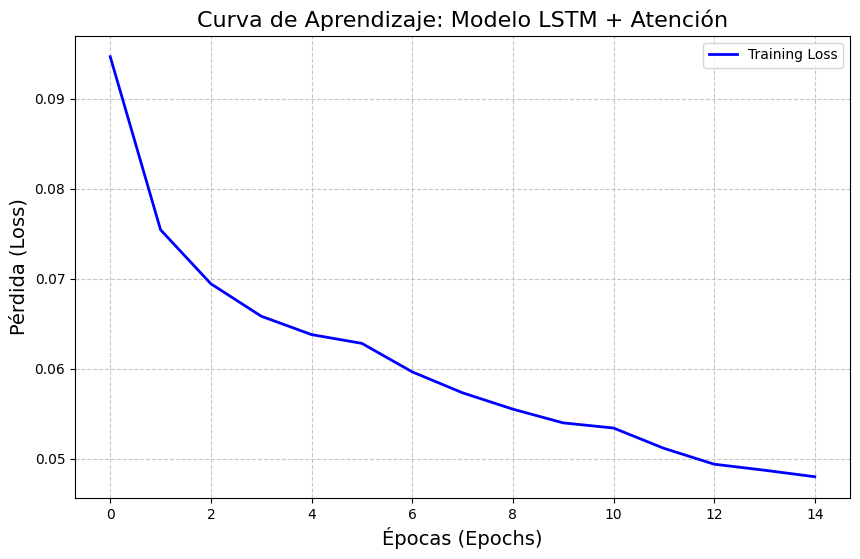


--- Generando Mapas de Calor de Atención ---


/tmp/ipython-input-225889315.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence.split(), fontdict=fontdict, rotation=90)
/tmp/ipython-input-225889315.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence.split(), fontdict=fontdict)


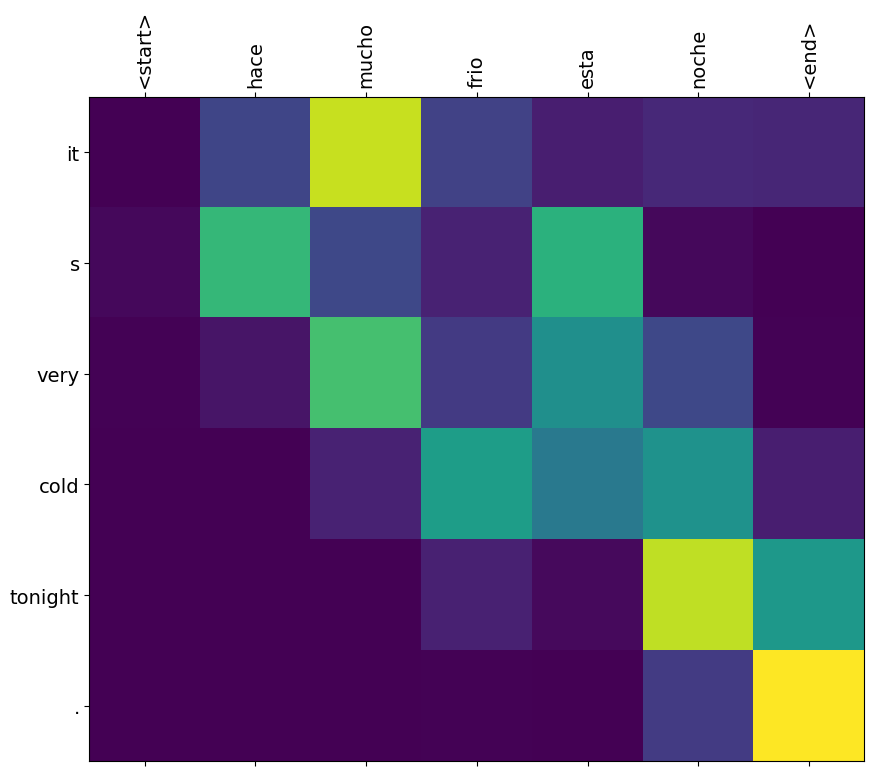

/tmp/ipython-input-225889315.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence.split(), fontdict=fontdict, rotation=90)
/tmp/ipython-input-225889315.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence.split(), fontdict=fontdict)


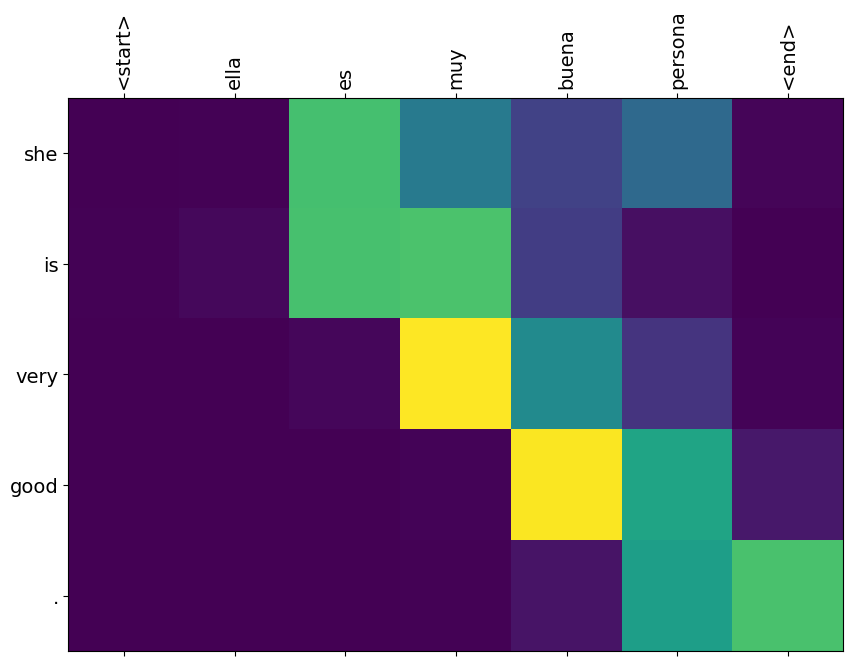

'she is very good .'

In [9]:
# --- BLOQUE 5: GRÁFICOS Y VISUALIZACIÓN DE MÉTRICAS ---
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# 1. GRÁFICO DE LA PÉRDIDA (LOSS) DURANTE EL ENTRENAMIENTO
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history, label='Training Loss', color='blue', linewidth=2)
    plt.title('Curva de Aprendizaje: Modelo LSTM + Atención', fontsize=16)
    plt.xlabel('Épocas (Epochs)', fontsize=14)
    plt.ylabel('Pérdida (Loss)', fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Asegúrate de tener la variable 'loss_history' del Bloque 3
if 'loss_history' in locals() and len(loss_history) > 0:
    plot_loss(loss_history)
else:
    print("No se encontró el historial de pérdida. Asegúrate de haber ejecutado el Bloque 3.")

# 2. VISUALIZACIÓN DE LA ATENCIÓN (HEATMAP)
# Esta función es clave para el "Informe Técnico"
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    # El gráfico de atención
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    # Etiquetas de los ejes
    ax.set_xticklabels([''] + sentence.split(), fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence.split(), fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def evaluar_y_graficar(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''

    hidden = [tf.zeros((1, units)), tf.zeros((1, units))]
    enc_out, enc_h, enc_c = encoder(inputs, hidden)
    dec_hidden = [enc_h, enc_c]
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        # Guardar los pesos de atención para visualizar
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        word = targ_lang.index_word[predicted_id]

        if word == '<end>':
            result = result.strip()
            # Graficar solo hasta la longitud de la frase generada
            plot_attention(attention_plot[:t, :len(sentence.split())], sentence, result)
            return result

        result += word + ' '
        dec_input = tf.expand_dims([predicted_id], 0)

    result = result.strip()
    plot_attention(attention_plot[:max_length_targ, :len(sentence.split())], sentence, result)
    return result

# --- EJECUTAR VISUALIZACIÓN ---
print("\n--- Generando Mapas de Calor de Atención ---")
# Prueba con frases interesantes para ver el alineamiento
evaluar_y_graficar(u'hace mucho frio esta noche')
evaluar_y_graficar(u'ella es muy buena persona')